In [1]:
import pandas as pd
from statistics import mean, stdev
import matplotlib.pyplot as plt
from os import listdir
from rlhfutils.eval_utils import scofile
from scipy.stats import pearsonr, spearmanr
import numpy as np
from datasets import Dataset

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-02-24 09:46:00,032] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/trl/trainer/ppo_config.py:142: UserWarning: The `optimize_cuda_cache` argument will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# TODO assert that the lengths work in the right way (limited to 50), otherwise these comparisons aren't useful anymore
# maybe also get a case for 25 to get stuff closer to the interesting range of what the RM can learn

In [4]:
def diffplot(scos, golds):
    sdiffs = []
    gdiffs = []
    for i in range(len(scos)):
        for j in range(i+1,len(scos)):
            if golds[i]>golds[j]:
                sdiffs.append(scos[i]-scos[j])
                gdiffs.append(golds[i]-golds[j])
            else:
                sdiffs.append(scos[j]-scos[i])
                gdiffs.append(golds[j]-golds[i])
    return sdiffs, gdiffs

# given alldfs, and a list of keys to merge, we're going to get n choose 2 pairs of indices, x will be score diff, y will be gold diff, then we'll measure the correlation (within each context)
def checkdistcorrs(adfs, selkeys, cfunct=pearsonr):
    # first merge all the scores across the adf keys (more diversity in scoring)
    scos = list(adfs[selkeys[0]]['scores'])
    golds = list(adfs[selkeys[0]]['gold'])
    for i in range(1, len(selkeys)):
        for j in range(len(scos)):
            scos[j] = scos[j]+adfs[selkeys[i]]['scores'].loc[j]
            #print(adfs[selkeys[i]]['scores'].loc[j])
            golds[j] = golds[j] + adfs[selkeys[i]]['gold'].loc[j]
    print(scos[0])
    sps = []
    gps = []
    corrs = []
    pvals = []
    # get the combination-based diff plots for all of these, then return that
    for i in range(len(scos)):
        sp, gp = diffplot(scos[i], golds[i])
        sps.append(sp)
        gps.append(gp)
        corrs.append(cfunct(gp, sp).statistic)
        pvals.append(cfunct(gp, sp).pvalue)
    print(np.nanmean(corrs))
    plt.hist(corrs)
    plt.scatter(corrs, pvals)
    return sps, gps

# for different gold values, what's the mean variance of RM scores for those
def unvar(slist, glist):
    uns = set(glist)
    gdict = {}
    for i in range(len(slist)): 
        gval = glist[i]
        if gval not in gdict.keys(): 
            gdict[gval] = []
        gdict[gval].append(slist[i])
    vdict = {g:(len(gdict[g]), stdev(gdict[g]) if len(gdict[g])>1 else 0) for g in gdict.keys()}
    mdict = {g:mean(gdict[g]) for g in gdict.keys()}
    return vdict, mdict

# forget about inputs, compute some info about the relationship between arbitrary pairs
def agginfo(adfs, selkeys):
    # first merge all the scores across the adf keys (more diversity in scoring)
    scos = list(adfs[selkeys[0]]['scores'])
    golds = list(adfs[selkeys[0]]['gold'])
    for i in range(1, len(selkeys)):
        for j in range(len(scos)):
            scos[j] = scos[j]+adfs[selkeys[i]]['scores'].loc[j]
            #print(adfs[selkeys[i]]['scores'].loc[j])
            golds[j] = golds[j] + adfs[selkeys[i]]['gold'].loc[j]
    ascos = []
    agolds = []
    for i in range(len(scos)):
        ascos.extend(scos[i])
        agolds.extend(golds[i])
    vard, md = unvar(ascos, agolds)
    print(vard)
    plt.errorbar(md.keys(), [md[k] for k in md.keys()], yerr=[vard[k][1] for k in vard.keys()], fmt='o')

In [148]:
# Check how well-calibrated RMs are over here
BASE = "../../outputs/nouns/calibcheck//"
filt = "1b"
# BASE = "../../outputs/bagofwords/calibcheck//"
# filt = "125mag"
funct = "nouns"
scodirs = listdir(BASE)
print(scodirs)
alldfs = {}
# go through and load everything in 
for s in scodirs:
    if filt in s:
        alldfs[s] = pd.read_json(BASE+s, lines=True, orient='records')
        # TODO add on the synthetic scoring piece
        #print(s)
        stmp, lens = scofile(BASE+s, funct, True)
        print(mean(lens))
        #print(stmp)
        alldfs[s]['gold'] = stmp[0]

['dpoplusnoun25.jsonl', 'dpoplusnoun50.jsonl', 'dpoplusnoun75.jsonl', 'dpoplusnoun100.jsonl', 'dpoplusnoun25_mininounrms_sco', 'dpoplusnoun50_mininounrms_sco', 'dpoplusnoun75_mininounrms_sco', 'dpoplusnoun100_mininounrms_sco', 'dpoplusnoun25_dponounsynth_125mag_rm_sco', 'dpoplusnoun50_dponounsynth_125mag_rm_sco', 'dpoplusnoun75_dponounsynth_125mag_rm_sco', 'dpoplusnoun100_dponounsynth_125mag_rm_sco', 'dpoplusnoun25_dponounsynth_125poverp_rm_sco', 'dpoplusnoun50_dponounsynth_125poverp_rm_sco', 'dpoplusnoun75_dponounsynth_125poverp_rm_sco', 'dpoplusnoun100_dponounsynth_125poverp_rm_sco', 'dpoplusnoun25_dponounsynth_1b_rm_sco', 'dpoplusnoun50_dponounsynth_1b_rm_sco', 'dpoplusnoun75_dponounsynth_1b_rm_sco', 'dpoplusnoun100_dponounsynth_1b_rm_sco']
[10.0, 14.5, 11.0, 18.5, 14.25, 14.25, 11.25, 12.75, 10.25, 12.25, 17.0, 13.75, 9.75, 13.25, 10.25, 13.75, 14.5, 15.0, 10.5, 15.0, 11.5, 13.75, 12.0, 12.25, 15.75, 12.75, 15.0, 16.25, 7.75, 16.75, 12.75, 13.75, 13.75, 14.5, 15.0, 12.75, 12.25, 12

In [149]:
print(alldfs.keys())

dict_keys(['dpoplusnoun25_dponounsynth_1b_rm_sco', 'dpoplusnoun50_dponounsynth_1b_rm_sco', 'dpoplusnoun75_dponounsynth_1b_rm_sco', 'dpoplusnoun100_dponounsynth_1b_rm_sco'])


In [150]:
def goldacc(indf):
    gpairs = []
    spairs = []
    cnt = 0
    tot=0
    for ind, row in indf.iterrows():
        for i in range(len(row['gold'])):
            for j in range(len(row['gold'])):
                if j<=i: 
                    continue
                if row['gold'][i]!=row['gold'][j]:
                    tot+=1
                    if (row['scores'][i]>row['scores'][j])==(row['gold'][i]>row['gold'][j]):
                        cnt+=1
    return cnt/tot

In [155]:
goldacc(alldfs["dpoplusnoun100_dponounsynth_1b_rm_sco"])

0.8434782608695652

In [103]:
alldfs.keys()

dict_keys(['dpoplusbow400_nozero100k_125mag_rm_sco', 'dpoplusbow200_nozero100k_125mag_rm_sco', 'dpoplusbow100_nozero100k_125mag_rm_sco', 'dpoplusbow25_nozero100k_125mag_rm_sco'])

[3.455078125, 1.482421875, 2.810546875, 1.08203125]
-0.031402553428665776


/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


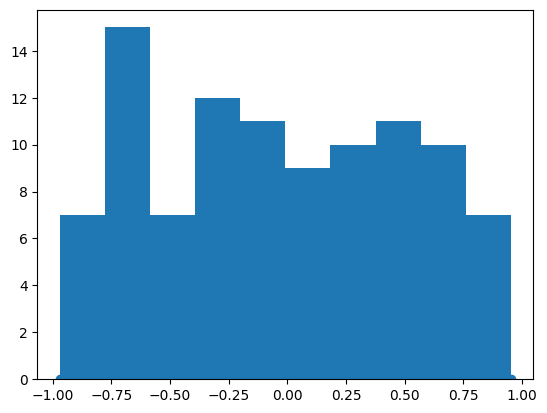

In [105]:
spvals, gpvals = checkdistcorrs(alldfs, ["dpoplusbow25_nozero100k_125mag_rm_sco"])

In [77]:
tmp = Dataset.load_from_disk("../../data/fixedreversebowdpo/")

In [78]:
tmp = pd.DataFrame(tmp)

In [79]:
tmp.score_j.quantile(0.95)

1.0

In [83]:
max(tmp['score_j'])

3.0

PearsonRResult(statistic=0.003938436759617613, pvalue=0.9233054996812565)

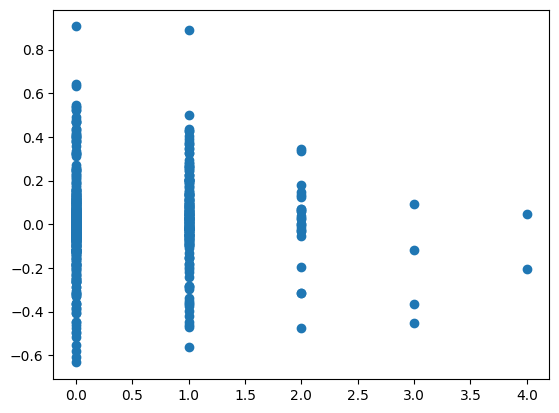

In [40]:
spv = []
gpv = []
for i in range(len(gpvals)):
    spv.extend(spvals[i])
    gpv.extend(gpvals[i])
plt.scatter(gpv, spv)
pearsonr(gpv, spv)

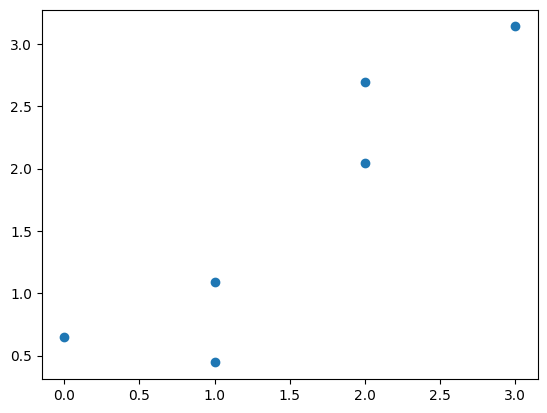

In [32]:
ind = 8
plt.scatter(gpvals[ind], spvals[ind])

In [84]:
import torch

In [87]:
scores = torch.tensor([0,1,2,3])

In [88]:
scores.unsqueeze(1) - scores.unsqueeze(0)

tensor([[ 0, -1, -2, -3],
        [ 1,  0, -1, -2],
        [ 2,  1,  0, -1],
        [ 3,  2,  1,  0]])

In [ ]:
pairwise_diff = scores.unsqueeze(1) - scores.unsqueeze(0)

# Apply absolute value and sigmoid
loss = torch.sigmoid(torch.abs(pairwise_diff))

In [92]:
it = iter([0,1,2,3,4,5])

In [102]:
for i in range(20):
    val = next(it)
    if val is not None:
        print(val)
    else:
        it = iter([0,1,2,3,4,5])

5


StopIteration: 

In [99]:
val = next(it)

In [101]:
val

4